In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
expr = pd.read_csv(r"C:\Users\Public\Documents\bioinformatics-gene-expression\data\processed\matrix.csv", index_col=0)

In [6]:
expr.head()

,Ctrl_1,Ctrl_2,Ctrl_3,PCOS_1,PCOS_2,PCOS_3
gene,,,,,,
PB.5769.4,20.02,0.00,0.00,21.28,18.83,21.28
PB.11528.1,40.04,0.00,20.89,42.56,56.48,21.28
PB.17701.1,20.02,0.00,0.00,0.00,0.00,0.00
PB.3407.382,20.02,0.00,0.00,0.00,0.00,0.00
PB.13560.38,20.02,90.09,41.77,106.41,131.78,85.14


In [7]:
groups = pd.Series(["Control", "Control", "Control", "PCOS"
, "PCOS", "PCOS"], index=expr.columns)

groups

Ctrl_1    Control
Ctrl_2    Control
Ctrl_3    Control
PCOS_1       PCOS
PCOS_2       PCOS
PCOS_3       PCOS
dtype: object

In [8]:
expr_log = np.log2(expr+1)

Log2(TPM+1) transformation was applied to reduced skewness.

In [9]:
X = expr_log.T
X_scaled = StandardScaler().fit_transform(X)


Data were standardized using z-score normalization prior to PCA
to prevent high-expression genes from dominating the analysis.


In [10]:

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(pcs, columns =["PC1", "PC2"], index =X.index)

pca_df["Group"] = groups.values
pca_df

,PC1,PC2,Group
Ctrl_1,111.097350,132.421087,Control
Ctrl_2,56.924745,-4.433543,Control
Ctrl_3,104.295337,166.966874,Control
PCOS_1,75.565778,16.228356,PCOS
PCOS_2,-390.724817,45.593609,PCOS
PCOS_3,42.841607,-356.776383,PCOS


PCA was applied to reduce the high-dimensional gene expression data
to two principal components for visualization of sample separation.


In [11]:
pca.explained_variance_ratio_


array([0.21443542, 0.20110147])

Principal Component Analysis showed that PC1 and PC2 explained
approximately 21.4% and 20.1% of the total variance, respectively.
Together, the first two components captured ~41.5% of the overall
transcriptomic variation among samples.


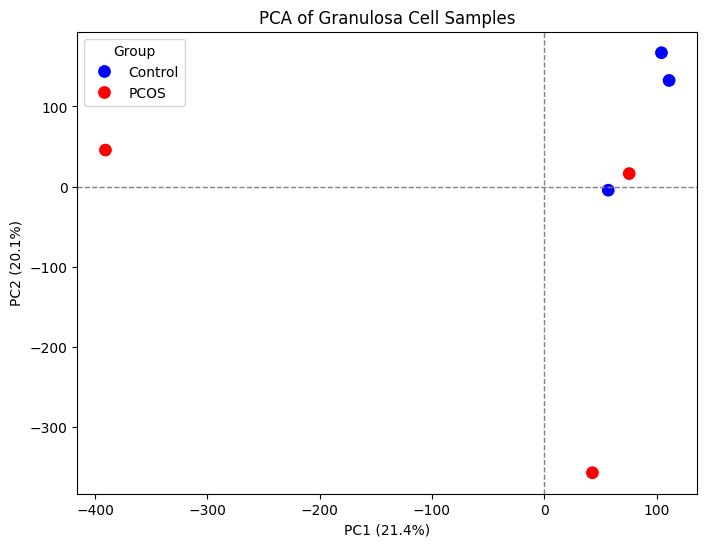

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="Group",
    data=pca_df,
    s=100,  # size of points
    palette={"Control": "blue", "PCOS": "red"}
)
plt.title("PCA of Granulosa Cell Samples")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.legend(title="Group")
plt.show()


Principal component analysis revealed partial separation between PCOS and control granulosa cell samples, although substantial within-group variability was observed, possibily because of biological heterogeneity and the small sample size.

In [25]:

from scipy.stats import ttest_ind

# Separate groups
ctrl_cols = ['Ctrl_1', 'Ctrl_2', 'Ctrl_3']
pcos_cols = ['PCOS_1', 'PCOS_2', 'PCOS_3']

ctrl = expr_log[ctrl_cols]
pcos = expr_log[pcos_cols]



In [26]:
# Calculate log2 fold-change
results = pd.DataFrame(index=expr_log.index)
results['log2FC'] = pcos.mean(axis=1) - ctrl.mean(axis=1)

# Compute p-values
pvals = []
for gene in expr_log.index:
    t_stat, p_val = ttest_ind(pcos.loc[gene], ctrl.loc[gene], equal_var=False)
    pvals.append(p_val)
results['pval'] = pvals

# Manual Benjamini-Hochberg FDR
pvals_sorted = np.sort(results['pval'])
m = len(pvals_sorted)
rank = np.argsort(np.argsort(results['pval'])) + 1  # ranks
results['adj_pval'] = results['pval'] * m / rank
results['adj_pval'] = results['adj_pval'].clip(upper=1)  # cap at 1

# Significant genes
results['significant'] = (results['adj_pval'] < 0.05) & (abs(results['log2FC']) > 1)
results.head()


,log2FC,pval,adj_pval,significant
gene,,,,
PB.5769.4,2.957092,0.180755,1.000000,False
PB.11528.1,1.985480,0.353241,1.000000,False
PB.17701.1,-1.464564,0.422650,0.651461,False
PB.3407.382,-1.464564,0.422650,0.652133,False
PB.13560.38,1.302350,0.158398,1.000000,False


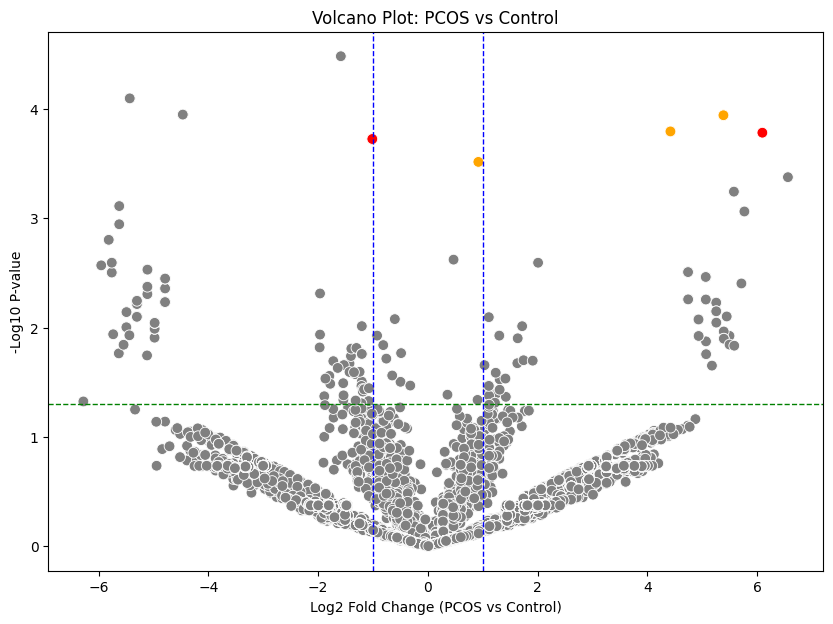

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create color categories
results['color'] = 'grey'  # default
results.loc[(abs(results['log2FC']) > 0.5) & (results['adj_pval'] < 0.1), 'color'] = 'orange'
results.loc[(abs(results['log2FC']) > 1) & (results['adj_pval'] < 0.05), 'color'] = 'red'

# Select top genes for labeling (by smallest p-value)
top_red = results[results['color']=='red'].sort_values('pval').head(5)
top_orange = results[results['color']=='orange'].sort_values('pval').head(5)

plt.figure(figsize=(10,7))
sns.scatterplot(
    x='log2FC',
    y=-np.log10(results['pval']),
    hue='color',
    data=results,
    palette={'red':'red','orange':'orange','grey':'grey'},
    legend=False,
    s=60
)

# Add cutoff lines
plt.axhline(-np.log10(0.05), color='green', linestyle='--', linewidth=1)
plt.axvline(1, color='blue', linestyle='--', linewidth=1)
plt.axvline(-1, color='blue', linestyle='--', linewidth=1)


plt.xlabel('Log2 Fold Change (PCOS vs Control)')
plt.ylabel('-Log10 P-value')
plt.title('Volcano Plot: PCOS vs Control')
plt.show()


olcano plot showing differential gene expression between PCOS and control granulosa cell samples. Red points represent strongly significant genes (|log2FC| > 1, FDR < 0.05), orange points represent suggestive genes (|log2FC| > 0.5, FDR < 0.1), and grey points are non-significant.

In [31]:
#red and orange genes
deg_table = results[results['color'].isin(['red','orange'])].copy()

# Keep relevant columns
deg_table = deg_table[['log2FC', 'pval', 'adj_pval', 'color']]

# Sort by adjusted p-value
deg_table = deg_table.sort_values('adj_pval')

# Reset index so gene names are a column
deg_table = deg_table.reset_index().rename(columns={'index':'Gene'})

# Show the table
deg_table


,gene,log2FC,pval,adj_pval,color
0,PB.15794.124,4.421656,0.000160,0.039532,red
1,PB.9657.16,4.421656,0.000160,0.039599,red
2,PB.7223.37,4.421656,0.000160,0.039667,red
3,PB.15962.16,4.421656,0.000160,0.039735,red
4,PB.1761.5,4.421656,0.000160,0.039803,red
...,...,...,...,...,...
427,PB.14844.2,-4.467236,0.000113,0.097220,orange
428,PB.10279.33,-4.467236,0.000113,0.097802,orange
429,PB.12483.3,-4.467236,0.000113,0.098391,orange
430,PB.505.3,-4.467236,0.000113,0.098988,orange


In [32]:
# Export DEG table to CSV
deg_table.to_csv("PCOS_DEGs_table.csv", index=False)
